In [1]:
from scipy.signal import find_peaks
import lightkurve as lk
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import find_peaks
import scipy.signal
from astropy import units as u
import nana

In [2]:
def get_started(num_of_peaks, xs, ys): 
    """
    
    Identifies and returns the indices of the highest peaks in a given dataset.
    
    Args:
        num_of_peaks (int): The number of highest peaks to return.
        xs (numpy.ndarray): The x-axis values 
        ys (numpy.ndarray): The y-axis values

    Returns:
        numpy array: An array of indices corresponding to the highest peaks in `ys`.

    Bugs:
        `num_of_peaks` cannot be greater than the number of detected peaks
        `xs` or `ys` must be NumPy array

    
    """
    indxs, properties = find_peaks(ys)
    return indxs[np.argsort(-ys[indxs])[:num_of_peaks]]

def check_inputs(xs):
    """
    
    Checks whether the input array `xs` is sorted in ascending order.

    Args:
        xs (numpy.ndarray or list): The input array to check.

    Returns:
        bool: `True` if `xs` is sorted in ascending order, otherwise `False`.
    
    """
    for i in range(len(xs)-1):
        if xs[i] > xs[i+1]:
            print("check_inputs(): input xs is badly ordered. Use reorder_inputs to reorder")
            return False
    return True

def reorder_inputs(xs,ys):
    """
    
    Reorders the input arrays `xs` and `ys` in ascending order of `xs`.

    Args:
        xs (numpy.ndarray): The x-axis values 
        ys (numpy.ndarray): The y-axis values
        
    Returns:
        tuple of numpy arrays (sorted xs, sorted ys)

    Bugs:
        `xs` or `ys` must be NumPy array
        `xs` and `ys`must be same length
        
    """
    i = np.argsort(xs)
    return xs[i], ys[i]

#xlist is the teh index left to highest peak, highest peak, and the index right to teh highest peak
def design_matrix(xlist): 
    """
    
    Constructs a design matrix for quadratic curve fitting.

    Args:
        xs (numpy.ndarray): The x-axis values 

    Returns:
        3 x 3 design matrix of numpy arrays

    Bugs:
        xlist must be an numpy array

    Note:
        Note the factor of 0.5 that Hogg likes and no one else
        Also assumes xlist is ordered
    
    """
    return (np.vstack((xlist**0,xlist**1,0.5*xlist**2))).T

def fit_parabola(xs, ys, index):
    """

    Fits a quadratic function to three consecutive data points. Solves for coefficients (b,m,q) in the quadratic
    f(x) = b + m*x + (1/2) * q * x^2

    Args:
        xs (numpy.ndarray): The x-axis values 
        ys (numpy.ndarray): The y-axis values
        index (int): The index of peak
        

    Returns:
        tuple: (b, m, q)

    Bugs: 
        index-1` or `index+2` can't be out of bounds
        ``xs` or `ys` must be NumPy array
        
    
    """
    return np.linalg.solve(design_matrix(xs[index-1:index+2]), ys[index-1:index+2])

def refine_peak(xs, ys, index):
    """

    Refines the peak position using quadratic fit

    Args:
        xs (numpy.ndarray): The x-axis values 
        ys (numpy.ndarray): The y-axis values
        index (int): The index of peak
    
    Returns:
        3-tuple: (x position of refined peak, y position of refined peak, and second derivative (q))

    Bugs:
        Must be synchronized with the design matrix
        
        
    """
    b,m,q = fit_parabola(xs, ys, index)
    x_peak = -m / q
    return x_peak, 0.5 * q * (x_peak) ** 2 + m * (x_peak) + b, q
    
def refine_peaks(xs, ys, indices):
    """

    Refines the peak position for a set of indices using quadratic fit

    Args:
        xs (numpy.ndarray): The x-axis values 
        ys (numpy.ndarray): The y-axis values
        indices (numpy array): indices of the peaks (this should be the output of get_started()

    Returns:
        three  numpy arrays (array of refined x positions, array of refined y positions, and the second derivatives)
    

    """
    foo = lambda i: refine_peak(xs,ys,i)
    xs_refined, ys_refined, second_derivatives = zip(*list(map(foo,indices)))
    return np.array(xs_refined), np.array(ys_refined), np.array(second_derivatives)x




In [3]:
search_result = lk.search_lightcurve('KIC 5202905', mission='Kepler')
lc_collection = search_result.download_all()

In [4]:
lc = lc_collection.stitch()
total_observation_time = (lc.time[-1] - lc.time[0]).value
delta_f = (1/total_observation_time) 
sampling_rate= np.median(np.diff(lc.time.value))
print(total_observation_time,sampling_rate)


1470.4622572100852 0.02043360086827306


In [5]:
f_max = (0.5 / (sampling_rate))
f_min = delta_f/3
frequency_grid = np.arange(f_min, f_max, f_min)/(u.day)

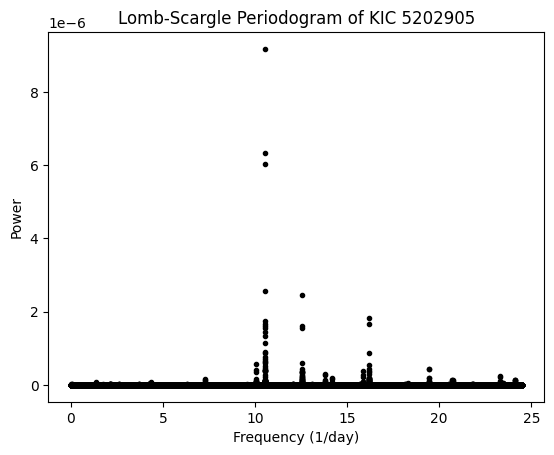

In [6]:
pg = lc.to_periodogram(
    #method='lombscargle',
    normalization='psd',
    frequency=frequency_grid
)

power = pg.power.value
freq = pg.frequency.to(1/u.day).value 

plt.plot(freq, power,'k.')
plt.xlabel("Frequency (1/day)")
plt.ylabel("Power")
plt.title("Lomb-Scargle Periodogram of KIC 5202905")
plt.show() 

In [7]:
indices = get_started(20, freq, power)
refined_freq, refined_power, second_derivatives = refine_peaks(freq,power, indices)

In [8]:
print(refined_freq, refined_power)

[10.54113514 10.54362996 12.56701919 16.17299573 10.53826448 10.53550181
 10.54206202 10.54641361 10.54273837 12.56952504 10.05192849 16.17548566
 19.44253463 12.56414063 15.84963682 16.17013612 12.56793488 13.77654431
 12.56140096 23.28943326] [9.17539455e-06 2.55840359e-06 2.44347348e-06 1.90195078e-06
 1.68638826e-06 1.14266629e-06 8.79501840e-07 7.64639083e-07
 6.06993240e-07 5.98530733e-07 5.78792481e-07 4.65800554e-07
 4.72359829e-07 4.39639166e-07 3.80579422e-07 3.50504934e-07
 3.33745106e-07 3.21724087e-07 2.79781261e-07 2.54464339e-07]


In [9]:
t = lc.time.value
flux = lc.flux.value
sigma = lc.flux_err.value
nu = refined_freq[0] #looking at highest power
print(nu)

10.541135137952823


In [10]:
t_clean = np.ma.filled(t, np.nan)
flux_clean = np.ma.filled(flux, np.nan)
sigma_clean = np.ma.filled(sigma, np.nan)

mask = np.isfinite(t_clean) & np.isfinite(flux_clean) & np.isfinite(sigma_clean) #good

lc = lc[mask]
t_fit = t_clean[mask]
flux_fit = flux_clean[mask]
sigma_fit = sigma_clean[mask]

In [11]:
lc_exptime = (6.52 * 270) / (60 * 60 * 24) #days, see Kepler Data Processing Handbook, Section 3.1

omega = 2 * np.pi * nu

# Design matrix

def easy_design_matrix(ts, om):
    return np.vstack([
        np.ones_like(ts),
        np.cos(om * ts),
        np.sin(om * ts)
    ]).T

def integral_design_matrix(ts, om, T):
    """
    ##bugs:
    - assumes all data points have the same exposure time, `T`
    - not numerically stable when `om * T` is small
    """
    return np.vstack([
        np.ones_like(ts),
        (+ np.sin(om * (ts + T/2)) - np.sin(om * (ts - T/2))) / (om * T),
        (- np.cos(om * (ts + T/2)) + np.cos(om * (ts - T/2))) / (om * T)
    ]).T

A_easy = easy_design_matrix(t_fit, omega)

A_integral = integral_design_matrix(t_fit, omega, lc_exptime)

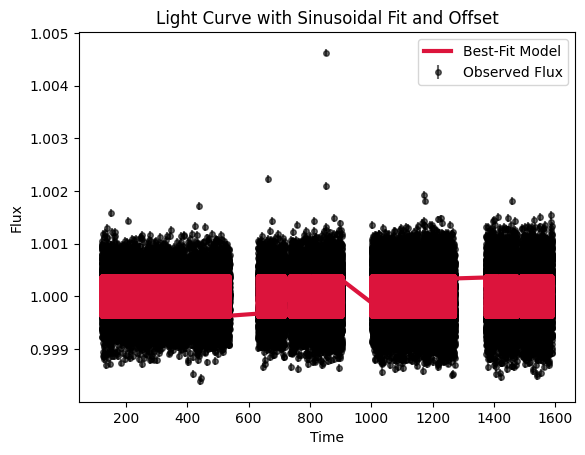

In [12]:
weight_fit = 1 / sigma_fit**2

def weighted_least_squares(A, b, weights):
    ATA = A.T @ (A * weights[:, np.newaxis])
    ATb = A.T @ (b * weights)
    return A @ np.linalg.solve(ATA, ATb)

y_hat = weighted_least_squares(A_integral, flux_fit, weight_fit)
     


# Plot observed flux (data)
plt.errorbar(
    t_fit, flux_fit, yerr=sigma_fit, fmt='o',
    label='Observed Flux', alpha=0.6, color='black', markersize=4, zorder=1
)

# Plot best-fit model (bold and on top)
plt.plot(
    t_fit, y_hat, color='crimson',
    label='Best-Fit Model', linewidth=3, zorder=2
)

# Labels and styling
plt.xlabel('Time')
plt.ylabel('Flux')
plt.title('Light Curve with Sinusoidal Fit and Offset')
plt.legend()
plt.show()
     

     
##why isn't the error bar as great?

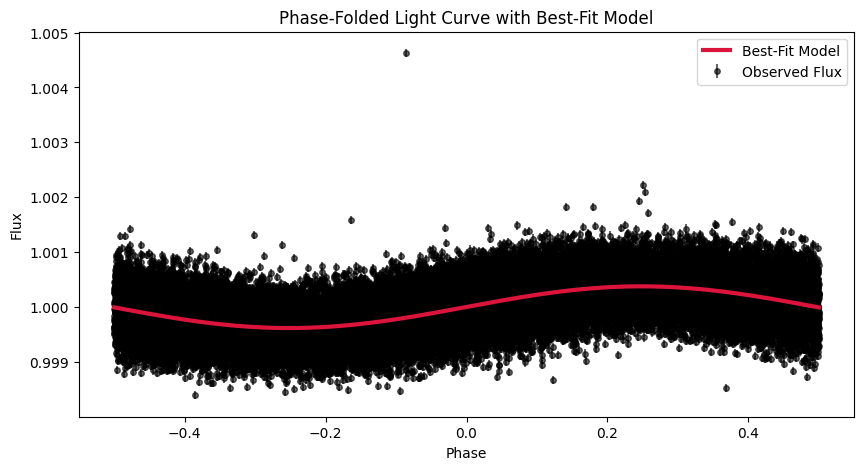

In [13]:
# Compute period from selected frequency
P = 1 / refined_freq[0]

# Reference time
t0 = t_fit[np.argmin(flux)] #this should center the phase around zero?

# phase folding over the select period
phase = ((t_fit - t0) % P) / P
phase[phase > 0.5] -= 1 # shifting range


# Sort for better plotting // i think data may already be sorted
sorted_indices = np.argsort(phase)
phase_sorted = phase[sorted_indices]
flux_sorted = flux_fit[sorted_indices]
sigma_sorted = sigma_fit[sorted_indices]
model_sorted = y_hat[sorted_indices]

# Plot
plt.figure(figsize=(10, 5))
plt.errorbar(
    phase_sorted, flux_sorted, yerr=sigma_sorted, fmt='o',
    label='Observed Flux', alpha=0.6, color='black', markersize=4, zorder=1
)
plt.plot(
    phase_sorted, model_sorted, color='crimson',
    label='Best-Fit Model', linewidth=3, zorder=2
)

# Labels and styling
plt.xlabel('Phase')
plt.ylabel('Flux')
plt.title('Phase-Folded Light Curve with Best-Fit Model')
plt.legend()
plt.show()

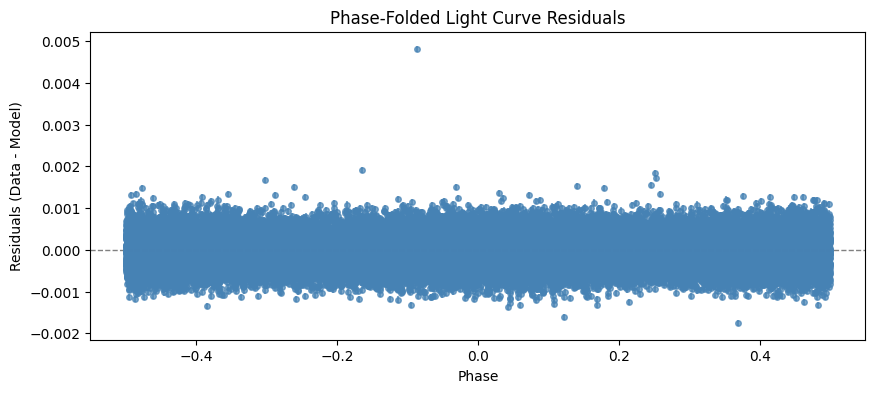

In [14]:
# Calculate residuals
residuals = flux_sorted - model_sorted

# Plot residuals
plt.figure(figsize=(10, 4))
plt.errorbar(
    phase_sorted, residuals, yerr=sigma_sorted, fmt='o',
    color='steelblue', alpha=0.7, markersize=4
)
plt.axhline(0, color='gray', linestyle='--', linewidth=1)

# Labels and styling
plt.xlabel('Phase')
plt.ylabel('Residuals (Data - Model)')
plt.title('Phase-Folded Light Curve Residuals')
plt.show()



In [15]:
def integral_chi_squared(om, ts, ys, ws, T):
    A = integral_design_matrix(ts, om, T)
    return np.sum(ws * (ys - weighted_least_squares(A, ys, ws))**2)

fine_freqs = np.arange(nu - 5 * f_min, nu + 5 * f_min, 0.2 * f_min)  # Adjusted range around nu
chi2_fine = np.array([integral_chi_squared(2. * np.pi * f, t_fit, flux_fit, weight_fit, lc_exptime) for f in fine_freqs])

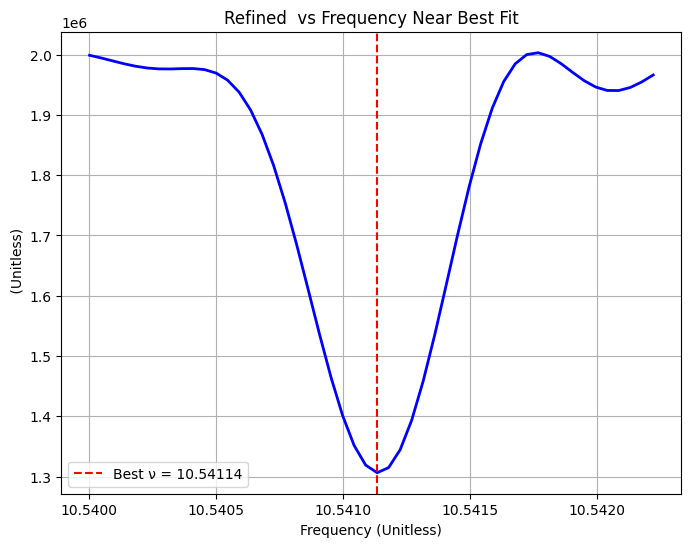

In [16]:
plt.figure(figsize=(8, 6))
plt.plot(fine_freqs, chi2_fine, 'b-', lw=2, label=r"")
plt.axvline(nu, color='red', linestyle='--', label=f'Best ν = {nu:.5f}')

plt.xlabel("Frequency (Unitless)")
plt.ylabel(r" (Unitless)")
plt.title(r"Refined  vs Frequency Near Best Fit")
plt.legend()
plt.grid(True)
plt.show()

In [17]:
#My original get_started function finds maxs, I'm trying to find mins

def get_mins(num_of_peaks, xs, ys): 
    """
    
    Identifies and returns the indices of the lowest peaks in a given dataset.
    
    Args:
        num_of_peaks (int): The number of lowest peaks to return.
        xs (numpy.ndarray): The x-axis values 
        ys (numpy.ndarray): The y-axis values

    Returns:
        numpy array: An array of indices corresponding to the lowest peaks in `ys`.

    Bugs:
        `num_of_peaks` cannot be greater than the number of detected peaks
        `xs` or `ys` must be NumPy array

    
    """
    indxs, properties = find_peaks(-ys)
    return indxs[np.argsort(-ys[indxs])[:num_of_peaks]]

In [18]:
min_index = get_mins(1, fine_freqs, chi2_fine)
print(min_index)

[7]


In [19]:
refined_nu, refined_nu_power, second_derivative_nu = refine_peaks(fine_freqs, chi2_fine, min_index)

In [20]:
print(refined_nu, refined_nu_power)

[10.54030667] [1975987.41015625]


In [21]:
print(nu) ###yay it's refined

10.541135137952823


In [22]:
def find_min_and_refine(xs,ys):
    indxs, properties = find_peaks(-ys)
    min_index =  indxs[np.argsort(-ys[indxs])[:1]]
    refined_x, refined_y, second_derivative = refine_peaks(xs, ys, min_index)
    return refined_x, refined_y

In [23]:
refined_nu, refined_nu_power = find_min_and_refine(fine_freqs, chi2_fine) 
print(refined_nu, refined_nu_power)

[10.54030667] [1975987.41015625]


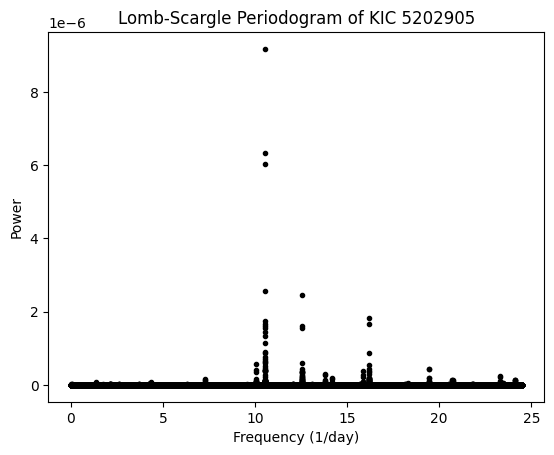

In [24]:
plt.plot(freq, power,'k.')
plt.xlabel("Frequency (1/day)")
plt.ylabel("Power")
plt.title("Lomb-Scargle Periodogram of KIC 5202905")
plt.show() 

##Top 20 peaks

indices = get_started(20, freq, power)


In [28]:
##The nu frequency used here is unrefined
num_of_mins = 20

indices = get_started(num_of_mins,freq,power)
nu_vals = []
best_freqs = []
best_chi2s = []

for index in indices:
    nu = freq[index]
    fine_freqs = np.arange(nu - 5 * f_min, nu + 5 * f_min, 0.2 * f_min)  
    chi2_fine = np.array([integral_chi_squared(2. * np.pi * f, t_fit, flux_fit, weight_fit, lc_exptime) for f in fine_freqs])
    best_freq, best_chi2 = find_min_and_refine(fine_freqs,chi2_fine)
    nu_vals.append(nu)
    best_freqs.append(best_freq.item())
    best_chi2s.append(best_chi2.item())

nu_vals = np.array(nu_vals)
best_freqs = np.array(best_freqs)
best_chi2s = np.array(best_chi2s)


arrays = np.vstack((nu_vals,best_freqs,best_chi2s))

print(arrays)



[[1.05411297e+01 1.05436232e+01 1.25670232e+01 1.61729188e+01
  1.05381828e+01 1.05354625e+01 1.05420364e+01 1.05463435e+01
  1.05427165e+01 1.25695168e+01 1.00519411e+01 1.61754123e+01
  1.94426389e+01 1.25640763e+01 1.58496644e+01 1.61701986e+01
  1.25679300e+01 1.37766202e+01 1.25613561e+01 2.32895018e+01]
 [1.05403076e+01 1.05444583e+01 1.25661053e+01 1.61720703e+01
  1.05391216e+01 1.05345794e+01 1.05427564e+01 1.05452820e+01
  1.05427564e+01 1.25686546e+01 1.00510017e+01 1.61762599e+01
  1.94416030e+01 1.25649481e+01 1.58486933e+01 1.61709530e+01
  1.25686546e+01 1.37755968e+01 1.25604747e+01 2.32884832e+01]
 [1.97597204e+06 1.99863994e+06 2.00105562e+06 2.00260619e+06
  2.00435671e+06 1.99849079e+06 1.95945759e+06 2.00011112e+06
  1.95945756e+06 1.99040166e+06 2.00514658e+06 2.00425209e+06
  2.00535784e+06 2.00420667e+06 2.00546482e+06 2.00553054e+06
  1.99040166e+06 2.00563922e+06 2.00334767e+06 2.00568564e+06]]


In [32]:
#Using peak refining code first

refined_peaks = refine_peaks(freq, power, indices)[0]

print(refined_peaks)


[10.54113514 10.54362996 12.56701919 16.17299573 10.53826448 10.53550181
 10.54206202 10.54641361 10.54273837 12.56952504 10.05192849 16.17548566
 19.44253463 12.56414063 15.84963682 16.17013612 12.56793488 13.77654431
 12.56140096 23.28943326]


In [33]:
#finding chi-squared minimum with refined frequency

nu_vals = []
best_freqs = []
best_chi2s = []

for peak in refined_peaks:
    nu = refined_peaks[peak]
    fine_freqs = np.arange(nu - 5 * f_min, nu + 5 * f_min, 0.2 * f_min)  
    chi2_fine = np.array([integral_chi_squared(2. * np.pi * f, t_fit, flux_fit, weight_fit, lc_exptime) for f in fine_freqs])
    best_freq, best_chi2 = find_min_and_refine(fine_freqs,chi2_fine)
    nu_vals.append(nu)
    best_freqs.append(best_freq.item())
    best_chi2s.append(best_chi2.item())

nu_vals = np.array(nu_vals)
best_freqs = np.array(best_freqs)
best_chi2s = np.array(best_chi2s)


arrays = np.vstack((nu_vals,best_freqs,best_chi2s))

print(arrays)


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices